## Hyperparameter Setting & Fix Random Seed

In [1]:
CFG = {
    'IMG_HEIGHT_SIZE':64,
    'IMG_WIDTH_SIZE':224,
    'EPOCHS':20,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':256,
    'NUM_WORKERS':4, # 본인의 GPU, CPU 환경에 맞게 설정
    'SEED':41
}

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import torch

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load & Split

In [3]:
import pandas as pd

df = pd.read_csv('train.csv')
df.head()

,id,img_path,label
0,TRAIN_00000,./train/TRAIN_00000.png,빨간색
1,TRAIN_00001,./train/TRAIN_00001.png,머
2,TRAIN_00002,./train/TRAIN_00002.png,차차
3,TRAIN_00003,./train/TRAIN_00003.png,써
4,TRAIN_00004,./train/TRAIN_00004.png,놓치다


In [4]:
# 제공된 학습데이터 중 1글자 샘플들의 단어사전이 학습/테스트 데이터의 모든 글자를 담고 있으므로 학습 데이터로 우선 배치
df['len'] = df['label'].str.len()
train_v1 = df[df['len']==1]

In [5]:
from sklearn.model_selection import train_test_split

# 제공된 학습데이터 중 2글자 이상의 샘플들에 대해서 단어길이를 고려하여 Train (80%) / Validation (20%) 분할
df = df[df['len']>1]
train_v2, val, _, _ = train_test_split(df, df['len'], test_size=0.2, random_state=CFG['SEED'])

In [6]:
train = pd.concat([train_v1, train_v2])

## Create LMDB Dataset

In [7]:
try:
    import lmdb
except ImportError:
    %pip install lmdb
    import lmdb

try:
    from tqdm import tqdm
except ImportError:
    %pip install tqdm
    from tqdm import tqdm
try:
    import fire
except ImportError:
    %pip install fire
    import fire

In [8]:
# save dir 생성
train_dir = './data/lmdb/train_lmdb'
val_dir = './data/lmdb/val_lmdb'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [9]:
def write_cache(env, cache):
    with env.begin(write=True) as txn:
        for k, v in cache.items():
            txn.put(k, v)

In [10]:
def write_lmdb(df, env, bar_desc='train'):
    cnt = 1
    cache = {}
    for i in tqdm(range(len(df)), desc=bar_desc):
        img_path = df.iloc[i]['img_path']
        label = df.iloc[i]['label']
        
        with open(img_path, 'rb') as f:
            img_bin = f.read()
        
        image_key = f'image-{cnt:09d}'.encode()
        label_key = f'label-{cnt:09d}'.encode()

        cache[image_key] = img_bin
        cache[label_key] = label.encode()

        if cnt % 1000 == 0:
            write_cache(env, cache)
            cache = {}
        cnt += 1

    # remain cache
    cache['num-samples'.encode()] = str(cnt-1).encode()
    write_cache(env, cache)

In [11]:
def create_and_write_lmdb():
    env_train = lmdb.open(train_dir, map_size=1099511627776)
    env_val = lmdb.open(val_dir, map_size=1099511627776)

    write_lmdb(train, env_train, bar_desc='train')
    write_lmdb(val, env_val, bar_desc='val')

    env_train.close()
    env_val.close()

In [22]:
fire.Fire(create_and_write_lmdb, command='')


val: 100%|██████████| 10637/10637 [00:01<00:00, 6592.69it/s]


## 생성이 잘 되었는지 체크

머


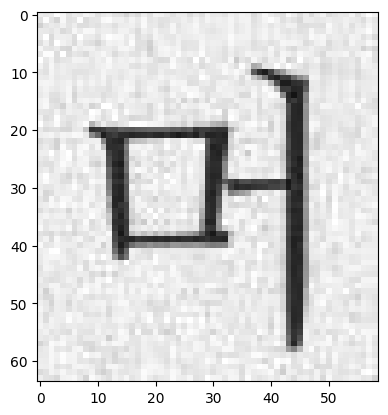

In [25]:
import cv2
import matplotlib.pyplot as plt

lmdb.open(train_dir, readonly=True, lock=False).stat()

# lmdb read
env = lmdb.open(train_dir, readonly=True, lock=False)
txn = env.begin()
label = txn.get('label-000000001'.encode()).decode()
img = cv2.imdecode(np.frombuffer(txn.get('image-000000001'.encode()), dtype=np.uint8), cv2.IMREAD_COLOR)
print(label)
plt.imshow(img)
